# Sheet 5

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [2]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[
    0
]  # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(
    dataset_name,
    "Llama3",
    "8B",
    "chat",
    layer=12,
    split=0.8,
    center=False,
    device="cpu",
    path_to_datasets=path_to_datasets,
    path_to_acts=path_to_acts,
)
acts_train, labels_train = dm.get("train")  # train set
acts_test, labels_test = dm.get("val")
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [3]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

### (a)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def get_data(dataset_name, split_name):
    # split_name - train/val
    dm = DataManager()
    dm.add_dataset(
        dataset_name,
        "Llama3",
        "8B",
        "chat",
        layer=12,
        split=0.8,
        center=False,
        device="cpu",
        path_to_datasets=path_to_datasets,
        path_to_acts=path_to_acts,
    )
    x, y = dm.get(split_name)
    return x.numpy(), y.numpy().astype(int)


def get_multi(names, split_name):
    xl = []
    yl = []
    for name in names:
        x, y = get_data(name, split_name)
        xl.append(x)
        yl.append(y)

    return np.concatenate(xl, axis=0), np.concatenate(yl, axis=0)


for name in dataset_names:
    x_train, y_train = get_data(name, "train")
    x_val, y_val = get_data(name, "val")

    clf = LogisticRegression(C=99999).fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    print(f"dataset {name}, accuracy: {accuracy_score(y_val, y_pred)}")

dataset cities, accuracy: 1.0
dataset neg_cities, accuracy: 1.0
dataset sp_en_trans, accuracy: 1.0
dataset neg_sp_en_trans, accuracy: 1.0


Activation vectors are linearly separable, since we get a perfect accuracy.

### (b)

In [5]:
datasets = dataset_names[1:]
print("validation datasets:", datasets)
for C in [1, 99999]:
    print(f"inverse regularization strength: {C}")
    for val_dataset in datasets:
        x_train, y_train = get_data("cities", "train")
        x_val, y_val = get_data(val_dataset, "val")
        clf = LogisticRegression(C=C).fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        print(f"validation: {val_dataset}, accuracy: {accuracy_score(y_val, y_pred)}")
    print("")

validation datasets: ['neg_cities', 'sp_en_trans', 'neg_sp_en_trans']
inverse regularization strength: 1
validation: neg_cities, accuracy: 0.5266666666666666
validation: sp_en_trans, accuracy: 1.0
validation: neg_sp_en_trans, accuracy: 0.5915492957746479

inverse regularization strength: 99999
validation: neg_cities, accuracy: 0.5
validation: sp_en_trans, accuracy: 0.9577464788732394
validation: neg_sp_en_trans, accuracy: 0.5915492957746479



We get generalization, especially with regularization, but not on statements
with negation.

### (c)

In [6]:
x_train, y_train = get_multi(dataset_names[:2], "train")
x_val, y_val = get_multi(dataset_names[2:], "val")
clf = LogisticRegression().fit(x_train, y_train)
y_pred = clf.predict(x_val)
print(f"accuracy: {accuracy_score(y_val, y_pred)}")

accuracy: 0.9788732394366197


After adding statements with negation to our training set, the situation improves.

## 3 Log-sum-exp and soft(arg)max
### (b)

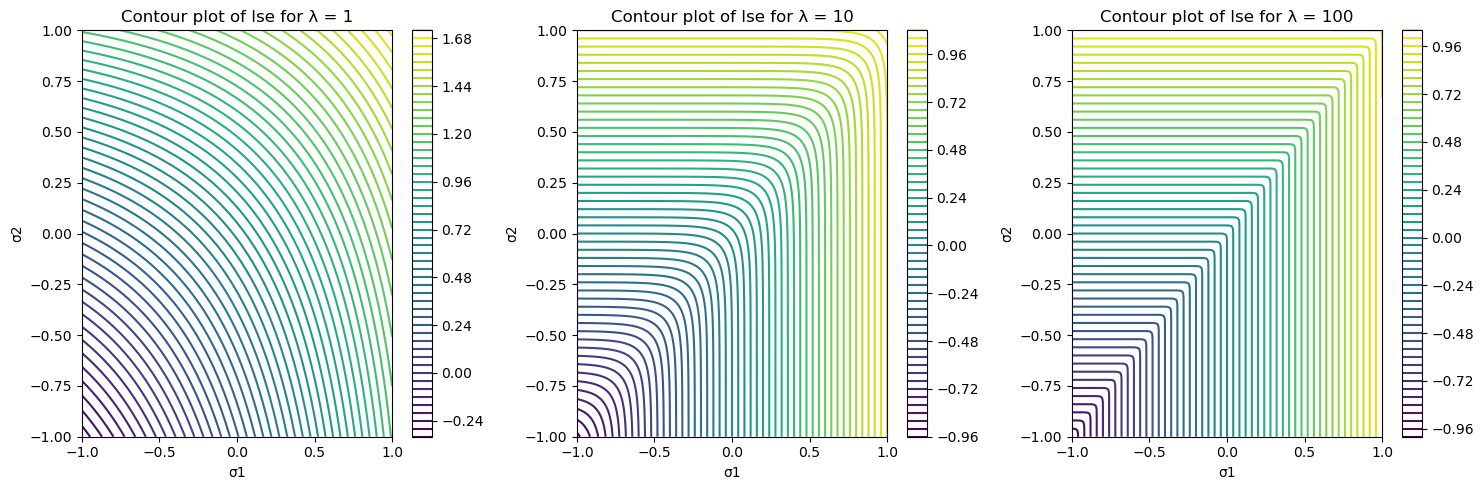

In [7]:
def lse(sig1, sig2, lamb):
    return np.log(np.exp(lamb * sig1) + np.exp(lamb * sig2)) / lamb


sig1_values = np.linspace(-1, 1, 200)
sig2_values = np.linspace(-1, 1, 200)
sig1_grid, sig2_grid = np.meshgrid(sig1_values, sig2_values)
lambdas = [1, 10, 100]

plt.figure(figsize=(15, 5))

for i, lamb in enumerate(lambdas):
    plt.subplot(1, 3, i + 1)
    z = lse(sig1_grid, sig2_grid, lamb)
    contour = plt.contour(sig1_grid, sig2_grid, z, levels=50, cmap="viridis")
    plt.colorbar(contour)
    plt.title(f"Contour plot of lse for λ = {lamb}")
    plt.xlabel("σ1")
    plt.ylabel("σ2")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'σ2')

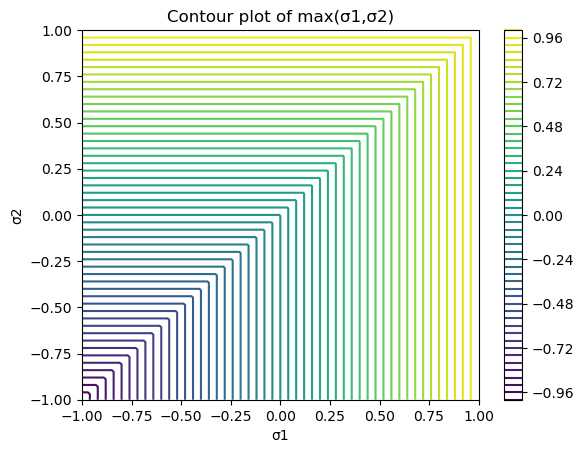

In [8]:
z2 = np.maximum(sig1_grid, sig2_grid)
contour = plt.contour(sig1_grid, sig2_grid, z2, levels=50, cmap="viridis")
plt.colorbar(contour)
plt.title(f"Contour plot of max(σ1,σ2)")
plt.xlabel("σ1")
plt.ylabel("σ2")

As we can see, the bigger lambda is, the closer we get to the max() function. This is because when lambda grows, one of the exponentials becomes the dominant one and the other is negligible.

### (c)

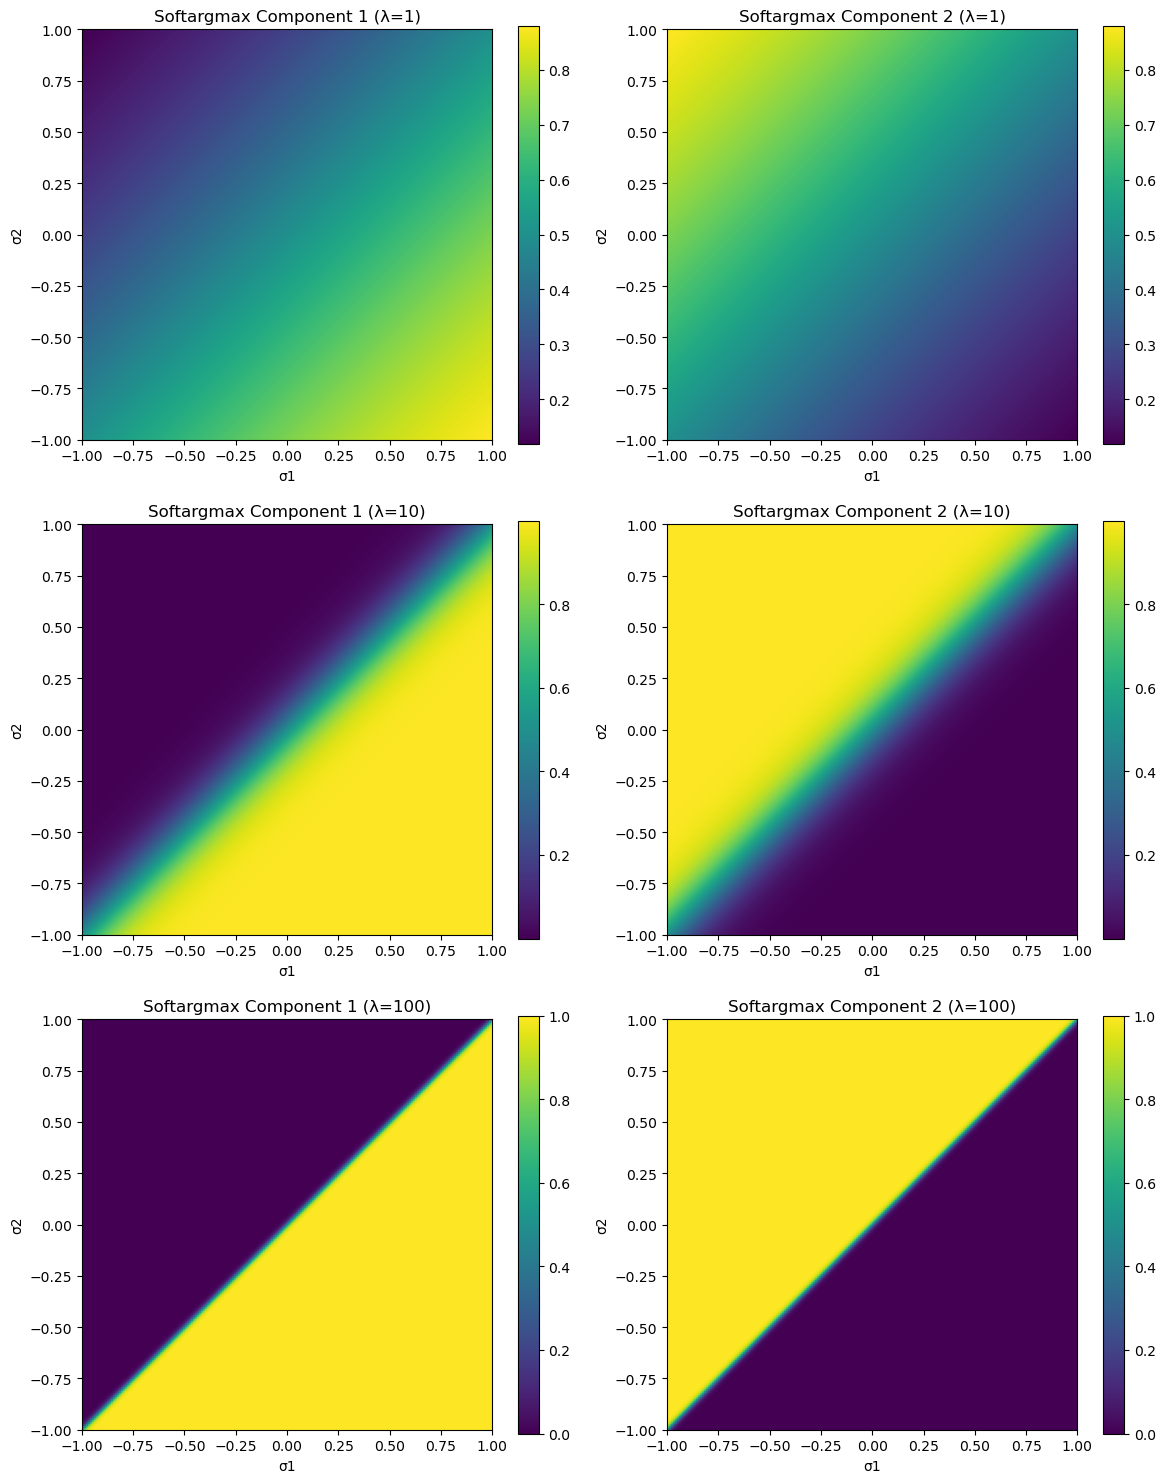

In [9]:
def softargmax(sig1, sig2, lambd):
    exp_sig1 = np.exp(lambd * sig1)
    exp_sig2 = np.exp(lambd * sig2)
    den = exp_sig1 + exp_sig2
    return exp_sig1 / den, exp_sig2 / den


fig, axes = plt.subplots(len(lambdas), 2, figsize=(12, 15))
for i, lambd in enumerate(lambdas):

    Z1, Z2 = softargmax(sig1_grid, sig2_grid, lambd)

    im1 = axes[i, 0].imshow(Z1, extent=(-1, 1, -1, 1), origin="lower", cmap="viridis")
    axes[i, 0].set_title(f"Softargmax Component 1 (λ={lambd})")
    axes[i, 0].set_xlabel("σ1")
    axes[i, 0].set_ylabel("σ2")
    fig.colorbar(im1, ax=axes[i, 0])

    im2 = axes[i, 1].imshow(Z2, extent=(-1, 1, -1, 1), origin="lower", cmap="viridis")
    axes[i, 1].set_title(f"Softargmax Component 2 (λ={lambd})")
    axes[i, 1].set_xlabel("σ1")
    axes[i, 1].set_ylabel("σ2")
    fig.colorbar(im2, ax=axes[i, 1])

plt.tight_layout()

plt.show()
plt.show()

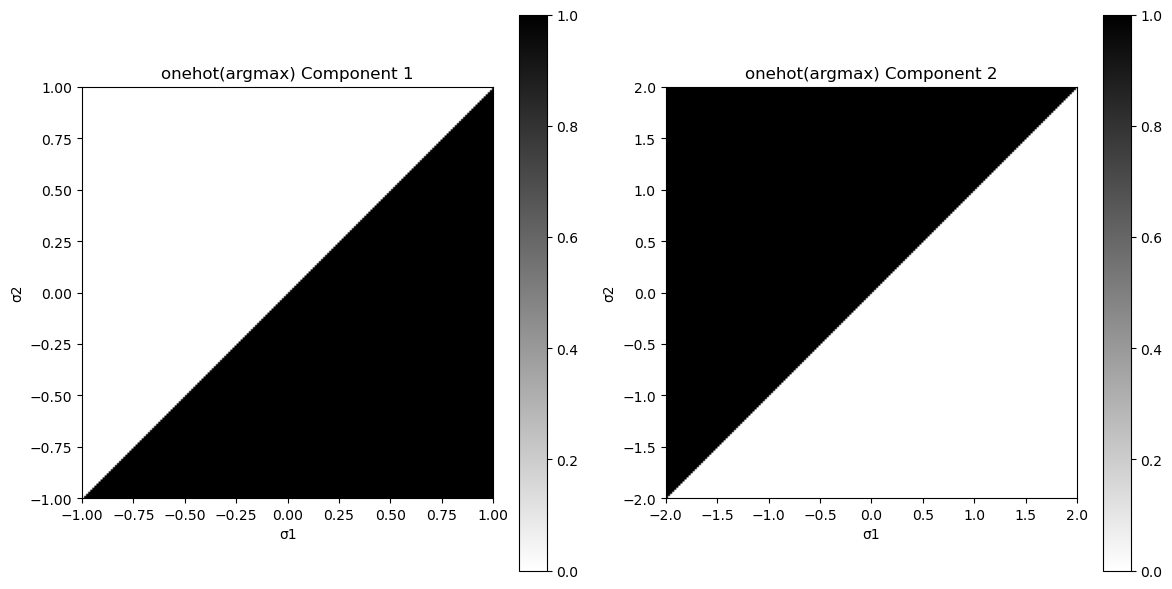

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
def onehot_argmax(sig1, sig2):
    argmax_1 = (sig1 > sig2).astype(float)
    argmax_2 = (sig2 >= sig1).astype(float)
    return argmax_1, argmax_2


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x, y = onehot_argmax(sig1_grid, sig2_grid)

im11 = axes[0].imshow(x, extent=(-1, 1, -1, 1), origin="lower", cmap="binary")
axes[0].set_title("onehot(argmax) Component 1")
axes[0].set_xlabel("σ1")
axes[0].set_ylabel("σ2")
fig.colorbar(im11, ax=axes[0])


im12 = axes[1].imshow(y, extent=(-2, 2, -2, 2), origin="lower", cmap="binary")
axes[1].set_title("onehot(argmax) Component 2")
axes[1].set_xlabel("σ1")
axes[1].set_ylabel("σ2")
fig.colorbar(im12, ax=axes[1])


plt.tight_layout()

plt.show()

plt.tight_layout()

plt.show()

plt.tight_layout()

plt.show()
plt.show()

As we can see, the smaller lambda is the smoother is the transition. However, when lambda grows softargmax becomes to be closer to onehotargmax due to the fact that one of the exponentials is much bigger that the other, basically it happens the same as in the previous case.

## 4 Linear regions of MLPs

### (a)

In [11]:
get_num_params = lambda x: sum(p.numel() for p in x.parameters())


class MLP(nn.Module):
    def __init__(self, dims: list[int], example: None | torch.Tensor):
        super().__init__()
        """

        Args:
            dims: list of layer output sizes
        """
        layers = []
        for i in dims:
            layers.append(nn.LazyLinear(i))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        self.net = nn.Sequential(*layers)

        if example is not None:
            self.net(example)

    def forward(self, x):
        return self.net(x)

In [12]:
model = MLP([20, 1], torch.Tensor([0, 0])).eval()
print("Number of parameters", get_num_params(model))

Number of parameters 81


### (b)

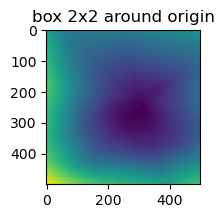

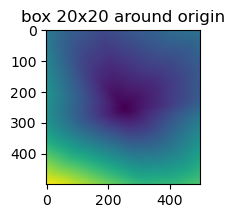

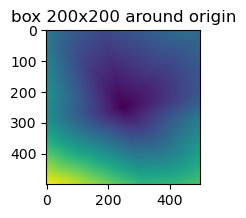

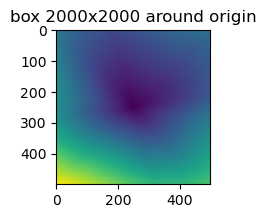

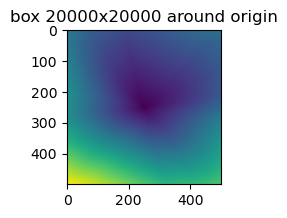

In [13]:
def get_square_output(model: nn.Module, side: int, points: int = 500) -> torch.Tensor:
    assert side > 0
    x = y = np.linspace(-side, side, points)
    xx, yy = np.meshgrid(x, y)
    grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

    grid_tensor = torch.Tensor(grid)
    with torch.no_grad():
        outputs = model(grid_tensor).numpy()

    return outputs.reshape(points, points)


def plot_square_output(model: nn.Module, side: int, points: int = 500):
    outputs = get_square_output(model, side, points)

    plt.figure(figsize=(2, 2))
    plt.title(f"box {side}x{side} around origin")
    plt.imshow(outputs)
    plt.show()


def plot_square_grad(model: nn.Module, side: int, points: int = 500):
    output = get_square_output(model, side, points)

    xgr, ygr = np.gradient(output)

    plt.figure()
    plt.title("df/dx")
    plt.imshow(xgr, cmap="prism")
    plt.show()

    plt.figure()
    plt.title("df/dy")
    plt.imshow(ygr, cmap="prism")
    plt.show()


plot_square_output(model, 2)
plot_square_output(model, 20)
plot_square_output(model, 200)
plot_square_output(model, 2000)
plot_square_output(model, 20000)

Structure stops changing already at 20x20, because the network is shallow and
parameters are initialized tightly around zero, including the bias term.

### (c)

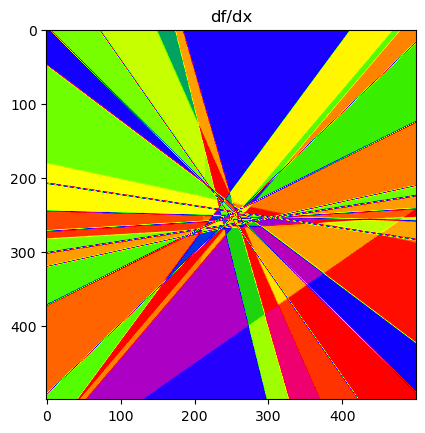

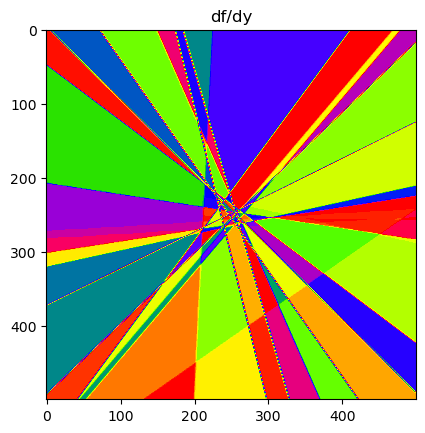

In [14]:
plot_square_grad(model, 20)

Here can see the regions of constant value of the function, since the
activation function is piecewise linear. We can see that discontinuities
intersect roughly at the origin, which once again demonstrates the small
initial bias term

### (d)

In [15]:
model = MLP([5, 5, 5, 5, 1], torch.Tensor([0, 0])).eval()
print("Number of parameters", get_num_params(model))

Number of parameters 111


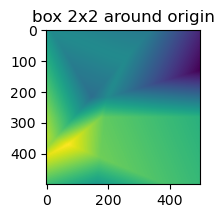

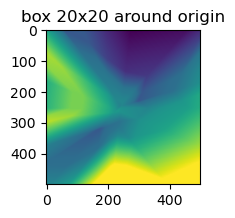

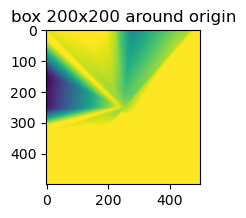

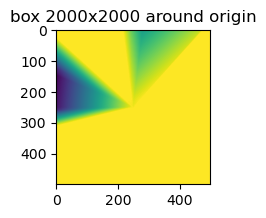

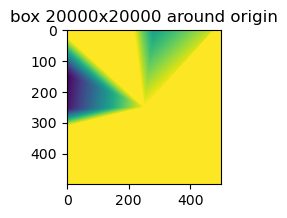

In [16]:
plot_square_output(model, 2)
plot_square_output(model, 20)
plot_square_output(model, 200)
plot_square_output(model, 2000)
plot_square_output(model, 20000)

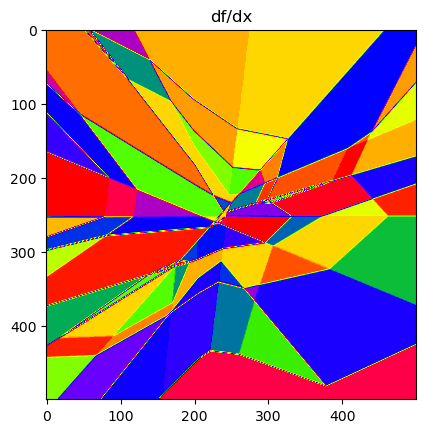

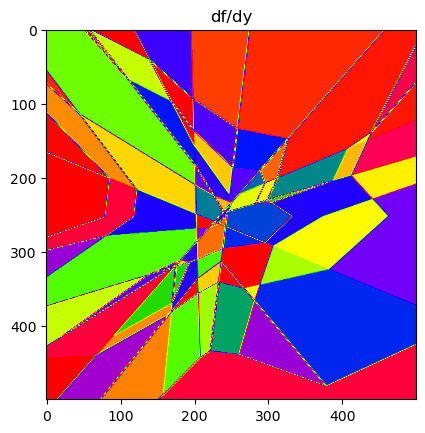

In [17]:
plot_square_grad(model, 20)

Despite having almost the same number of parameters, the deeper model shows
structure on a much larger scale, which is especially easy to see on the
gradient plot. Successively applying ReLU and linear transformations allows us
to gradually shift the inputs.

# 5 Number of linear regions

This is equivalent to finding the maximum number of regions a set of n lines can divide a plane into. If we have $n$ lines, the new line can introduce at most $n+1$ regions. Thus:

$$
a_{n+1} = a_n + n + 1
$$
$$
a_0 = 1
$$
$$
a_1 = 2
$$
Using induction hypothesis:
$$
a_n = \frac{(n+1)n}{2} + 1
$$
$$
a_{n+1} = \frac{(n+1)(n+2)}{2} + 1 = a_n + n + 1
$$
qed